# 1. Import Libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.dates as mdates
import calendar
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 2. Load Data and Display Rows

In [2]:
file_path = "Customer Support Tickets.xlsx"
df = pd.read_excel(
    file_path,
    sheet_name="tickets",
    parse_dates=["first_response_at", "resolved_at"],
    engine="openpyxl"
)

df


,Ticket ID,first_response_at,resolved_at,channel,priority,resolution_lag_hrs,sla_breached,satisfaction_rating,escalated_from_bot
0,1,2025-04-19 19:28:14,2025-04-19 20:49:39.196000,Phone,Normal,1.356999,False,4,True
1,2,2025-04-19 23:52:35,2025-04-20 00:20:27.278000,Email,Normal,0.464522,False,5,False
2,3,2025-04-19 01:59:20,2025-04-19 02:02:44.232000,Chat,Normal,0.056731,False,2,False
3,4,2025-04-19 09:27:59,2025-04-19 21:46:11.557000,Email,Normal,12.303488,False,4,False
4,5,2025-04-19 02:36:50,2025-04-19 02:43:14.587000,Chat,Normal,0.106830,False,5,False
...,...,...,...,...,...,...,...,...,...
6440,6441,2025-07-17 23:12:20,2025-07-18 15:03:43.983000,Chat,Low,15.856662,False,4,False
6441,6442,2025-07-17 21:26:56,2025-07-17 22:08:34.130000,Email,High,0.693925,False,4,False
6442,6443,2025-07-17 11:15:29,2025-07-17 11:31:14.461000,Email,Urgent,0.262628,False,4,True
6443,6444,2025-07-17 10:01:31,2025-07-17 15:20:24.413000,Email,Normal,5.314837,False,5,False


# 3. Exploration for Cleaning Data

In [3]:
# Step X: Check for nulls in the First Response column
print("Nulls in 'date' before cleaning:", df['first_response_at'].isna().sum())

# If any nulls exist, drop those rows
df = df.dropna(subset=['first_response_at'])

# Verify no nulls remain in First Response column
print("Nulls in 'date' after cleaning:", df['first_response_at'].isna().sum())


Nulls in 'date' before cleaning: 0
Nulls in 'date' after cleaning: 0


# 4. Resolution Time Calculation


In [4]:
df['first_response_at'] = pd.to_datetime(df['first_response_at'], errors='coerce')
df['resolved_at']       = pd.to_datetime(df['resolved_at'],    errors='coerce')

# 5.2 Compute resolution time
df['resolution_time'] = (
    df['resolved_at'] - df['first_response_at']
).dt.total_seconds() / 3600

# 5.3 Derive a simple date for grouping
df['date'] = df['first_response_at'].dt.date

# Quick check
df.loc[:, ['first_response_at','resolved_at','resolution_time','date']].head(10)



,first_response_at,resolved_at,resolution_time,date
0,2025-04-19 19:28:14,2025-04-19 20:49:39.196,1.356999,2025-04-19
1,2025-04-19 23:52:35,2025-04-20 00:20:27.278,0.464522,2025-04-19
2,2025-04-19 01:59:20,2025-04-19 02:02:44.232,0.056731,2025-04-19
3,2025-04-19 09:27:59,2025-04-19 21:46:11.557,12.303488,2025-04-19
4,2025-04-19 02:36:50,2025-04-19 02:43:14.587,0.106830,2025-04-19
5,2025-04-19 08:25:52,2025-04-19 17:37:42.932,9.197481,2025-04-19
6,2025-04-19 02:13:16,2025-04-19 05:12:34.142,2.988373,2025-04-19
7,2025-04-19 21:28:17,2025-04-20 06:28:47.989,9.008608,2025-04-19
8,2025-04-19 07:13:22,2025-04-19 10:56:43.556,3.722654,2025-04-19
9,2025-04-19 23:25:24,2025-04-20 00:38:18.667,1.215185,2025-04-19


# 5. Flag SLA Breaches 

In [5]:
sla_rules = {'Low': 48, 'Normal': 24, 'High': 4, 'Urgent': 1}
df['sla_breached'] = df.apply(
    lambda row: row['resolution_time'] > sla_rules[row['priority']],
    axis=1
)
df['resolution_time'] = df['resolution_time'].round(2)

df[df['sla_breached']].head(10)

,Ticket ID,first_response_at,resolved_at,channel,priority,resolution_lag_hrs,sla_breached,satisfaction_rating,escalated_from_bot,resolution_time,date
7,8,2025-04-19 21:28:17,2025-04-20 06:28:47.989,Phone,High,9.008608,True,4,False,9.01,2025-04-19
8,9,2025-04-19 07:13:22,2025-04-19 10:56:43.556,Chat,Urgent,3.722654,True,4,False,3.72,2025-04-19
13,14,2025-04-19 02:00:34,2025-04-19 07:43:51.656,Email,High,5.721571,True,4,False,5.72,2025-04-19
20,21,2025-04-19 23:40:51,2025-04-20 06:14:41.471,Email,Urgent,6.564020,True,3,False,6.56,2025-04-19
21,22,2025-04-19 16:36:48,2025-04-20 22:39:30.968,Social media,Normal,30.045269,True,4,True,30.05,2025-04-19
27,28,2025-04-19 02:06:59,2025-04-19 03:34:13.292,Email,Urgent,1.453970,True,3,False,1.45,2025-04-19
35,36,2025-04-19 16:16:43,2025-04-19 21:12:20.271,Social media,Urgent,4.927020,True,3,True,4.93,2025-04-19
36,37,2025-04-19 23:28:48,2025-04-21 06:54:35.746,Chat,Normal,31.429929,True,1,False,31.43,2025-04-19
47,48,2025-04-19 14:33:31,2025-04-19 18:52:34.221,Chat,High,4.317561,True,3,False,4.32,2025-04-19
49,50,2025-04-19 13:27:04,2025-04-20 20:33:13.911,Email,Normal,31.102753,True,2,True,31.10,2025-04-19


# 6. Aggregate Data

In [7]:
# Step 7: Aggregate daily metrics
daily = df.groupby('date').agg(
    ticket_volume      = ('Ticket ID',           'count'),
    avg_resolution_hrs = ('resolution_time',  'mean'),
    sla_breach_rate    = ('sla_breached',        'mean'),
    avg_satisfaction   = ('satisfaction_rating', 'mean')
).reset_index()
daily

,date,ticket_volume,avg_resolution_hrs,sla_breach_rate,avg_satisfaction
0,2025-04-19,66,8.263939,0.212121,4.090909
1,2025-04-20,70,6.954857,0.142857,4.185714
2,2025-04-21,72,6.575417,0.180556,4.291667
3,2025-04-22,55,6.993636,0.200000,4.127273
4,2025-04-23,97,7.919381,0.113402,4.298969
...,...,...,...,...,...
85,2025-07-13,68,7.202647,0.088235,4.397059
86,2025-07-14,73,7.030959,0.068493,4.178082
87,2025-07-15,86,6.876163,0.162791,4.151163
88,2025-07-16,72,7.515833,0.194444,4.180556


# 7. Forcast Calculation Prediction for July 18

In [12]:
daily['forecast_vol'] = daily['ticket_volume'].rolling(window=7, min_periods=1).mean()
pred       = daily['forecast_vol'].iloc[-1]
threshold  = daily['ticket_volume'].mean() * 1.2

print(f"Forecast for tomorrow: {int(pred)} tickets (threshold {int(threshold)})")
if pred > threshold:
    print("High volume expected")
else:
    print("✔ Volume within normal range")


Forecast for tomorrow: 75 tickets (threshold 85)
✔ Volume within normal range


# 8. Actual vs Forecast Ticket Volume Graph 

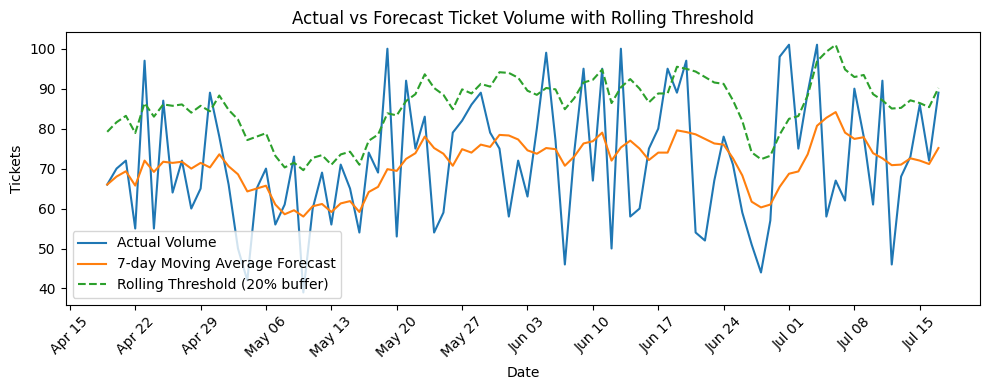

In [18]:
daily['rolling_avg'] = daily['ticket_volume'].rolling(window=7, min_periods=1).mean()
daily['rolling_threshold'] = daily['rolling_avg'] * 1.2

# Plot Actual vs Forecast vs Rolling Threshold
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(daily['date'], daily['ticket_volume'],      label='Actual Volume')
ax.plot(daily['date'], daily['forecast_vol'],       label='7-day Moving Average Forecast')
ax.plot(daily['date'], daily['rolling_threshold'],  label='Rolling Threshold (20% buffer)', linestyle='--')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Labels and legend
ax.set_title('Actual vs Forecast Ticket Volume with Rolling Threshold')
ax.set_xlabel('Date')
ax.set_ylabel('Tickets')
ax.legend()

plt.tight_layout()
plt.show()

# 9. Ticket Count Prediction for the remainder of July (18-31)

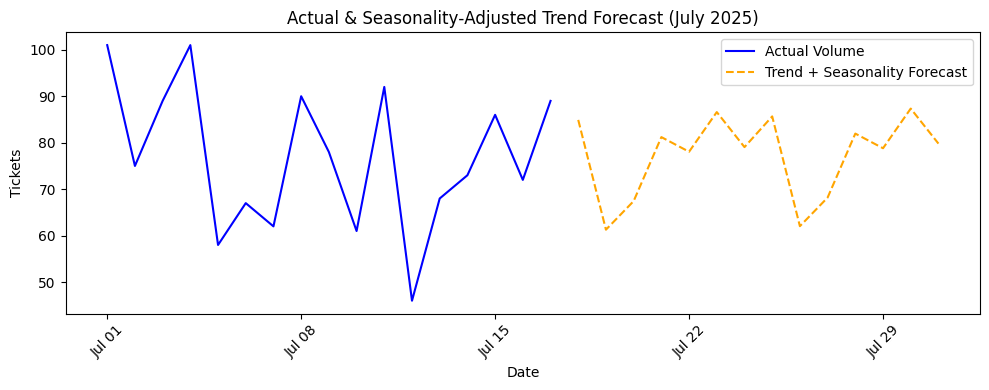

,date,forecast_july
0,2025-07-18,85
1,2025-07-19,62
2,2025-07-20,68
3,2025-07-21,82
4,2025-07-22,79
5,2025-07-23,87
6,2025-07-24,80
7,2025-07-25,86
8,2025-07-26,63
9,2025-07-27,69


In [22]:
#Fit linear trend model on full history
daily_sorted = daily.sort_values('date').reset_index(drop=True)
daily_sorted['day_index'] = np.arange(len(daily_sorted))
coef = np.polyfit(daily_sorted['day_index'], daily_sorted['ticket_volume'], 1)
trend = np.poly1d(coef)

# Compute weekday seasonal factors (avg deviation from trend per weekday)
daily_sorted['weekday'] = pd.to_datetime(daily_sorted['date']).dt.weekday
daily_sorted['trend_val'] = trend(daily_sorted['day_index'])
daily_sorted['seasonal_diff'] = daily_sorted['ticket_volume'] - daily_sorted['trend_val']
weekday_factors = daily_sorted.groupby('weekday')['seasonal_diff'].mean().to_dict()

# Build July forecast with trend + seasonality
last_idx = daily_sorted['day_index'].iloc[-1]
future_dates = pd.date_range(start=daily_sorted['date'].max() + pd.Timedelta(days=1),
                             end='2025-07-31', freq='D')
future = pd.DataFrame({
    'date': future_dates.date,
    'day_index': np.arange(last_idx + 1, last_idx + 1 + len(future_dates))
})
future['weekday'] = future_dates.weekday
future['forecast_july'] = (
    trend(future['day_index']) +
    future['weekday'].map(weekday_factors)
)

# Plot Actual vs Seasonality‑adjusted Trend Forecast for July
fig, ax = plt.subplots(figsize=(10,4))
# Actual
july_actual = daily[(daily['date'] >= pd.to_datetime('2025-07-01').date()) & 
                    (daily['date'] <= pd.to_datetime('2025-07-17').date())]
ax.plot(july_actual['date'], july_actual['ticket_volume'], label='Actual Volume', color='blue')
# Forecast
ax.plot(future['date'], future['forecast_july'], label='Trend + Seasonality Forecast',
        color='orange', linestyle='--')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

ax.set_title('Actual & Seasonality‑Adjusted Trend Forecast (July 2025)')
ax.set_xlabel('Date')
ax.set_ylabel('Tickets')
ax.legend()
plt.tight_layout()
plt.show()

future['forecast_july'] = np.ceil(future['forecast_july']).astype(int)

# Display the table of dates and expected ticket counts
future[['date', 'forecast_july']]

# 10. Breach Rate per Channel

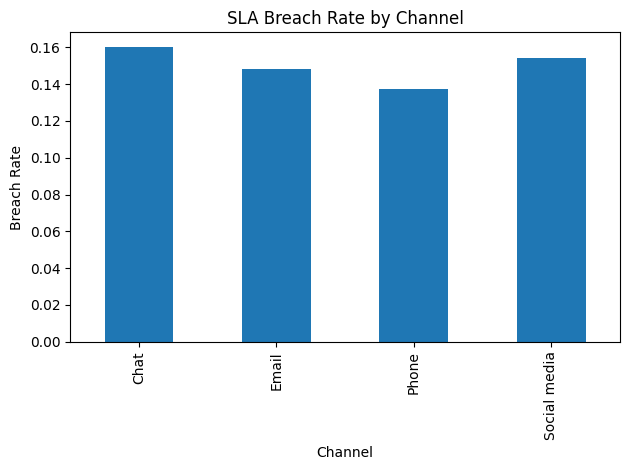

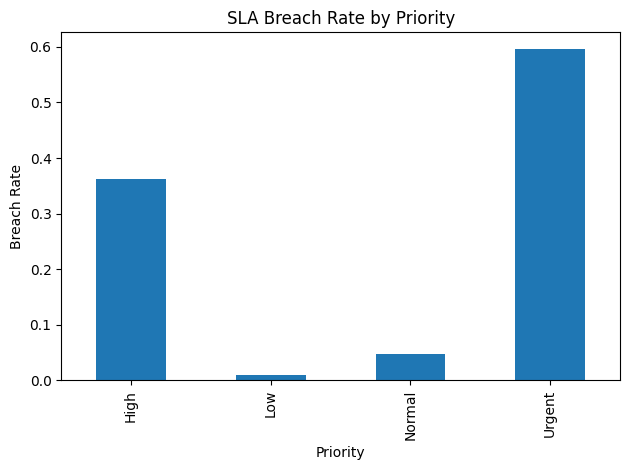

In [24]:
# Step: SLA Breach Rate by Channel & Priority

# 1. Calculate breach rates
chan_breach = df.groupby('channel')['sla_breached'].mean()
prio_breach = df.groupby('priority')['sla_breached'].mean()

# 2. Plot breach rate by channel
plt.figure()
chan_breach.plot(kind='bar')
plt.title('SLA Breach Rate by Channel')
plt.xlabel('Channel')
plt.ylabel('Breach Rate')
plt.tight_layout()
plt.show()

# 3. Plot breach rate by priority
plt.figure()
prio_breach.plot(kind='bar')
plt.title('SLA Breach Rate by Priority')
plt.xlabel('Priority')
plt.ylabel('Breach Rate')
plt.tight_layout()
plt.show()

# 11. Forecast Accuracy Evaluation

In [33]:
eval_df = daily.iloc[7:].copy()
y_true = eval_df['ticket_volume']
y_pred = eval_df['forecast_vol'] 

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = (np.abs((y_true - y_pred) / y_true).mean() * 100)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f} %")


Mean Absolute Error: 11.85
Root Mean Squared Error: 14.58
Mean Absolute Percentage Error: 17.62 %
